In [30]:
# ===================================================================
#  Library
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import warnings
warnings.simplefilter("ignore")

from tqdm.auto import tqdm

import unicodedata

import lightgbm as lgb

In [31]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    seed = 42
    n_splits = 10
    data_dir = "G:/マイドライブ/signate_StudentCup2023/data/"
    target_bins = 10
    year_bins = 10
    num_boost_round = 10000
    stopping_rounds = 500
    save_dir = "G:/マイドライブ/signate_StudentCup2023/exp/"

In [32]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    

def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [33]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [34]:
# ===================================================================
#  preprocessing
# ===================================================================
# year
def pre_year(df: pd.DataFrame):
    year_dict = {
        2999:1999,
        3008:2008,
        3015:2015,
        3017:2017,
        3011:2011,
        3019:2019,
    }
    df["year"] = df["year"].replace(year_dict)
    return df
all_data = pre_year(all_data)


# manufacturer
all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(lambda x: unicodedata.normalize('NFKC', x))


# fuel
all_data["fuel"].fillna(value=-1, inplace=True)


# size
def pre_size(df: pd.DataFrame):
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    df["size"] = df["size"].replace(size_dict)
    return df
all_data = pre_size(all_data)


# title_status
all_data["title_status"].fillna(value=-1, inplace=True)


# type
all_data["type"].fillna(value=-1, inplace=True)


# state
all_data["state"].fillna(value=-1, inplace=True)

In [35]:
# ===================================================================
#  train test split
# ===================================================================
from sklearn.model_selection import StratifiedKFold

train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="id", ignore_index=True, inplace=True)

train["year_map"], bins = pd.cut(train["year"], bins=CFG.year_bins, labels=False, retbins=True)
test["year_map"] = pd.cut(test["year"], bins=bins, labels=False)
train["price_map"] = pd.cut(train["price"], bins=CFG.target_bins, labels=False)

if False:
    kf = MultilabelStratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
    for i, (_, val) in enumerate(kf.split(X=train, y=train[["year_map", "price_map", 'region', 'manufacturer', 'condition', 'cylinders', 'fuel',
                                                            'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']])):
        train.loc[val, "fold"] = i
else:
    skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
    for i, (_, val) in enumerate(skf.split(X=train, y=train["price_map"])):
        train.loc[val, "fold"] = i
train["fold"].value_counts()

1.0    2754
0.0    2754
2.0    2753
4.0    2753
6.0    2753
3.0    2753
7.0    2753
8.0    2753
5.0    2753
9.0    2753
Name: fold, dtype: int64

In [36]:
# ===================================================================
#  use features
# ===================================================================
CFG.use_features = ['region', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 
                    'transmission', 'drive', 'size', 'type', 'paint_color', 'state']

CFG.categorical_features = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 
                            'drive', 'size', 'type', 'paint_color', 'state']

In [37]:
# ===================================================================
#  model
# ===================================================================
fold = 0
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
feature_importance_df["feature"] = CFG.use_features


X_train = train[train["fold"] != fold].reset_index(drop=True)
X_valid = train[train["fold"] == fold].reset_index(drop=True)

CFG.categorical_features_1 = ['year_map', "fuel", "condition"]
CFG.categorical_features_2 = ['year_map', "fuel"]

# fix odometer
inplace_odometer_rows = X_train[(X_train["odometer"] < 100)|(X_train["odometer"] > 400000)].reset_index(drop=True)
inplace_odometer_rows_ = X_valid[(X_valid["odometer"] < 100)|(X_valid["odometer"] > 400000)].reset_index(drop=True)
inplace_odometer_rows__ = test[(test["odometer"] < 100)|(test["odometer"] > 400000)].reset_index(drop=True)

print(inplace_odometer_rows.shape)
print(inplace_odometer_rows_.shape)
print(inplace_odometer_rows__.shape)

# カテゴリカル特徴量の値を元にグループ分けし、各グループごとの"odometer"の平均を計算します
grouped_means_1 = X_train.groupby(CFG.categorical_features_1)["odometer"].mean().to_dict()
grouped_means_2 = X_train.groupby(CFG.categorical_features_2)["odometer"].mean().to_dict()


keys_1 = tuple([k for k, v in grouped_means_1.items()])
keys_2 = tuple([k for k, v in grouped_means_2.items()])
print(len(keys_1))
print(len(keys_2))

for id_ in inplace_odometer_rows["id"]:
    tmp_1 = tuple(inplace_odometer_rows[inplace_odometer_rows["id"] == id_][CFG.categorical_features_1].values.tolist()[0])
    tmp_2 = tuple(inplace_odometer_rows[inplace_odometer_rows["id"] == id_][CFG.categorical_features_2].values.tolist()[0])
    
    if tmp_1 in keys_1:
        X_train.loc[X_train["id"] == id_, "odometer"] = grouped_means_1[tmp_1]
    elif tmp_2 in keys_2:
        X_train.loc[X_train["id"] == id_, "odometer"] = grouped_means_2[tmp_2]
        print(f"fillna {CFG.categorical_features_2}")
    else:
        raise ValueError("")
        
        
for id_ in inplace_odometer_rows_["id"]:
    tmp_1 = tuple(inplace_odometer_rows_[inplace_odometer_rows_["id"] == id_][CFG.categorical_features_1].values.tolist()[0])
    tmp_2 = tuple(inplace_odometer_rows_[inplace_odometer_rows_["id"] == id_][CFG.categorical_features_2].values.tolist()[0])
    if tmp_1 in keys_1:
        X_valid.loc[X_valid["id"] == id_, "odometer"] = grouped_means_1[tmp_1]
    elif tmp_2 in keys_2:
        X_valid.loc[X_valid["id"] == id_, "odometer"] = grouped_means_2[tmp_2]
        print(f"fillna {CFG.categorical_features_2}")
    else:
        raise ValueError("")
        
for id_ in inplace_odometer_rows__["id"]:
    tmp_1 = tuple(inplace_odometer_rows__[inplace_odometer_rows__["id"] == id_][CFG.categorical_features_1].values.tolist()[0])
    tmp_2 = tuple(inplace_odometer_rows__[inplace_odometer_rows__["id"] == id_][CFG.categorical_features_2].values.tolist()[0])

    if tmp_1 in keys_1:
        test.loc[test["id"] == id_, "odometer"] = grouped_means_1[tmp_1]
    elif tmp_2 in keys_2:
        test.loc[test["id"] == id_, "odometer"] = grouped_means_2[tmp_2]
        print(f"fillna {CFG.categorical_features_2}")
    else:
        raise ValueError("")

(250, 20)
(27, 20)
(125, 18)
144
41


In [38]:
X_train["odometer"].describe(),X_valid["odometer"].describe(),test["odometer"].describe(), 

(count     24778.000000
 mean     116790.062405
 std       58786.113082
 min          -1.000000
 25%       79821.000000
 50%      111905.000000
 75%      150874.750000
 max      392519.000000
 Name: odometer, dtype: float64,
 count      2754.000000
 mean     117006.638191
 std       59670.112636
 min         126.000000
 25%       80501.250000
 50%      112990.500000
 75%      150966.750000
 max      396512.000000
 Name: odometer, dtype: float64,
 count     27537.000000
 mean     117123.548393
 std       58531.757379
 min         121.000000
 25%       80772.000000
 50%      112754.000000
 75%      150451.000000
 max      394595.000000
 Name: odometer, dtype: float64)

In [39]:
CFG.categorical_features = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 
                            'drive', 'size', 'type', 'paint_color', 'state']

for col in CFG.categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_valid[col] = X_valid[col].astype("category")
    test[col] = test[col].astype("category")

In [40]:
# params
lgb_param = {
    "objective": "regression",
    "metric": 'mape',
    "verbosity": -1,
    "seed" : CFG.seed,
}

# train
lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train["price"], categorical_feature = CFG.categorical_features,)
lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid["price"], categorical_feature = CFG.categorical_features,)

model = lgb.train(
                lgb_param, 
                lgb_train, 
                num_boost_round=CFG.num_boost_round, 
                valid_sets=[lgb_valid],
                categorical_feature = CFG.categorical_features,
                callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=False)],
                )

# feature importance
feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

# eval
X_valid[f"pred"] = model.predict(X_valid[CFG.use_features])
print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

# concat
oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

# pred test
preds.append(model.predict(test[CFG.use_features]))

fold0: 62.52512540536455


66.41204170093509

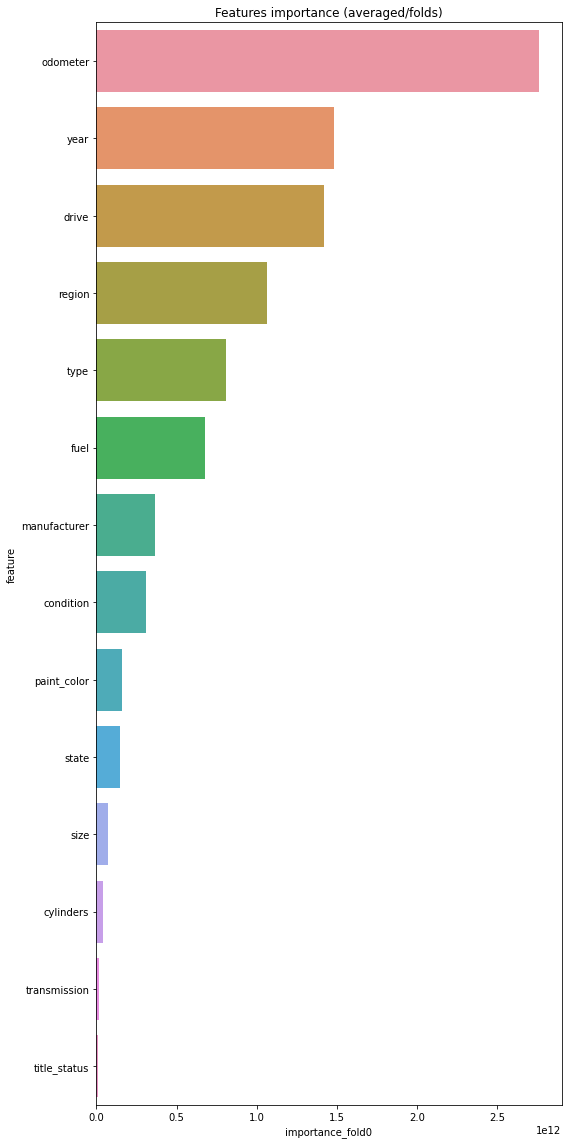

In [41]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
best_features = feature_importance_df[["feature", "importance_fold0"]].groupby("feature", as_index=False).mean().sort_values(by="importance_fold0", ascending=False).head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x="importance_fold0", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [42]:
feature_importance_df.sort_values("importance_fold0", ascending = False, ignore_index=True)

,feature,importance_fold0
0,odometer,2.761406e+12
1,year,1.480021e+12
2,drive,1.417015e+12
3,region,1.065027e+12
4,type,8.083948e+11
5,fuel,6.788577e+11
6,manufacturer,3.656719e+11
7,condition,3.075305e+11
8,paint_color,1.599838e+11
9,state,1.480207e+11
